# Project: Colorectal Polyp Segmentation on Kvasir-SEG Dataset

In this project, which is intended as a final project for Artificial Intelligence course in University of Tehran, department of computer science, we will use machine learning for segmentation of colorectal polyps images obtained from Kvasir-SEG dataset, an open-source dataset made available for study of computer vision methods in medical imaging processing field.

Colorectal polyps are precursors to colorectal cancer, which is why detection of such polyps and possibly their removal can help reduce cancer risk. Early detection can be life saving and detection of this polyp has a high miss-rate. This is why advancing machine learning methods in helping professionals in detection of these polyps is highly important. 

### 1. Importing Necessary Packages and Loading the Dataset
First, we import all the necessary modules, libraries and files. This includes TensorFlow for building neural networks, NumPy for linear algebra and Kvasir-SEG dataset which contains annotated images of polyps in the gastrointenstinal tract and segmentation masks for them.

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

2024-02-09 16:38:11.644494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, '/Users/mobin/Downloads/Kvasir-SEG/images/')
mask_path = os.path.join(path, '/Users/mobin/Downloads/Kvasir-SEG/masks/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### 2. Familiarizing with Kvasir-SEG Dataset

Checking out some of the images and checking for information like the size of the dataset.

In [5]:
len(image_list)

1000

With each run of the following code block a random image and its corresponding segmentation mask are displayed side by side to get a feel for the dataset.

/var/folders/3g/ck__19pn39n1h09w7lc_g74r0000gn/T/ipykernel_4044/4182686395.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/var/folders/3g/ck__19pn39n1h09w7lc_g74r0000gn/T/ipykernel_4044/4182686395.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

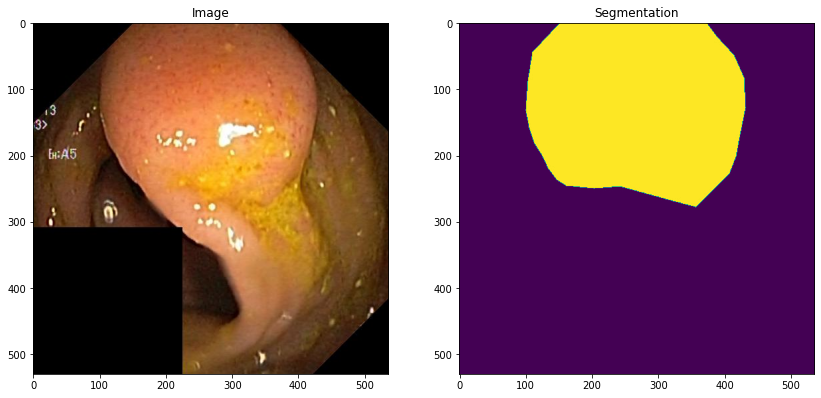

In [6]:
N = np.random.randint(0, 1000)
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### 3. Preprocess the Data (Normalizing, Resizing, ...)

In [7]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In preprocessing of the images they are decoded, converted, resized and normalized:

In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255
    input_mask = input_mask / 255

    # Ensure mask is binary after resizing
    input_mask = tf.where(input_mask > 0.5, 1, 0)

    return input_image, input_mask


image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

Result of some images after preprocessing is displayed below:

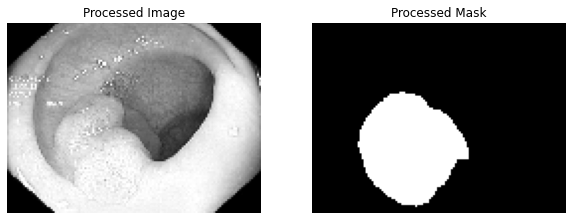

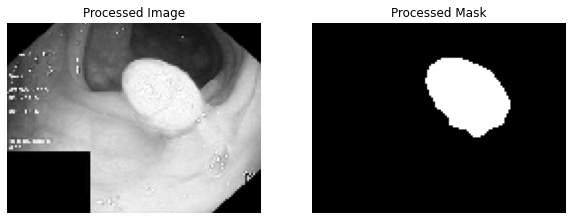

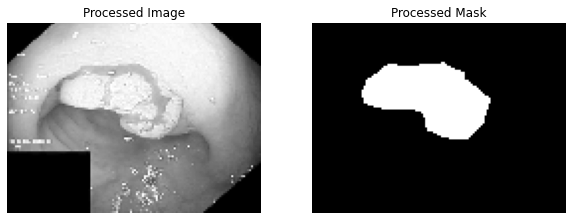

In [9]:
import matplotlib.pyplot as plt

# Take the first few examples from the processed dataset
for img, mask in processed_image_ds.take(3):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img.numpy()[:,:,0], cmap='gray')
    plt.title('Processed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy()[:, :, 0], cmap='gray')  # Assuming mask is single-channel
    plt.title('Processed Mask')
    plt.axis('off')

    plt.show()


### 4. U-Net
U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. The U-Net is a type of convolutional neural network in which the initial covolution and pooling stages lead to transpose convolution layers that that upsamples the feature map back to the size of the original input image which was reduced due to convolution and pooling. This model is widely used for medical image segmentation, which is why we will use it here for segmentation of colorectal polyps.

This model consists an encoder and a decoder section. The encoder section is made up of repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling.

In the decoder section, expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU.

In its final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes (two in our case).

One important aspcet of U-Nets are the residual neural network-like skip connections from the earlier encoder layers to the later decoding ones.

In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """ Implement a convolution block that downsampling """

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    
    conv = Conv2D(n_filters,
                  3,
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [11]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """ Implement convolutional upsampling block """
    """ 
    expansive_input, is the previous layer given as input
    contractive_input, is the skip connection layer given as input
    """
    up = Conv2DTranspose(
                 n_filters, 
                 3,
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [12]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """ The full U-net model implemented """
    
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)

    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)

    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)

    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)

    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [13]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [14]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [105]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.MeanIoU(num_classes=2), 'accuracy'])


In [106]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(529, 622, 1)


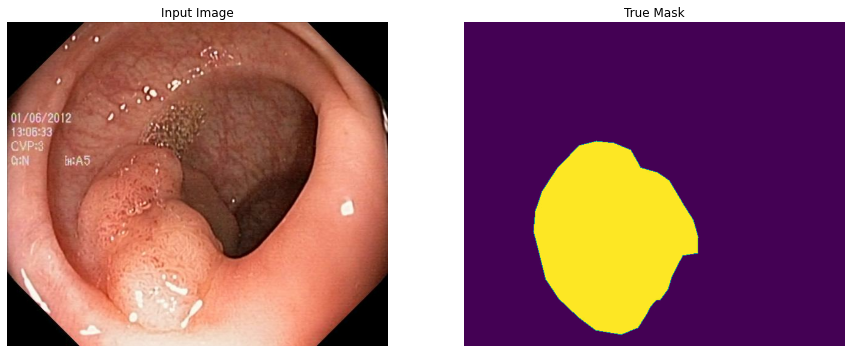

In [107]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


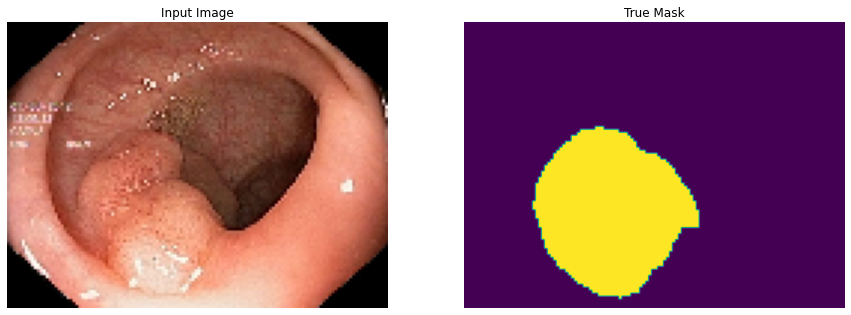

In [108]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [109]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.int32, name=None))
Epoch 1/40


32/32 [==============================] - 138s 4s/step - loss: 0.3193 - mean_io_u_2: 0.4230 - accuracy: 0.8603
Epoch 2/40
32/32 [==============================] - 130s 4s/step - loss: 0.2715 - mean_io_u_2: 0.4230 - accuracy: 0.8918
Epoch 3/40
32/32 [==============================] - 160s 5s/step - loss: 0.2522 - mean_io_u_2: 0.4230 - accuracy: 0.8991
Epoch 4/40
32/32 [==============================] - 149s 5s/step - loss: 0.2435 - mean_io_u_2: 0.4230 - accuracy: 0.9042
Epoch 5/40
32/32 [==============================] - 135s 4s/step - loss: 0.2289 - mean_io_u_2: 0.4230 - accuracy: 0.9089
Epoch 6/40
32/32 [==============================] - 131s 4s/step - loss: 0.2090 - mean_io_u_2: 0.4232 - accuracy: 0.9159
Epoch 7/40
32/32 [==============================] - 132s 4s/step - loss: 0.2004 - mean_io_u_2: 0.4237 - accuracy: 0.9207
Epoch 8/40
32/32 [==============================] - 131s 4s/step - loss: 0.1880 - mean_io_u_2: 0.4230 - accuracy: 0.9276
Epoch 9/40
32/32 [=========================

In [110]:
def create_mask(pred_mask, threshold=0.1):
    pred_mask = pred_mask > threshold  # Apply threshold
    return pred_mask[0]

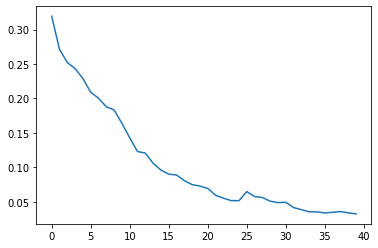

In [111]:
plt.plot(model_history.history["loss"])

In [112]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


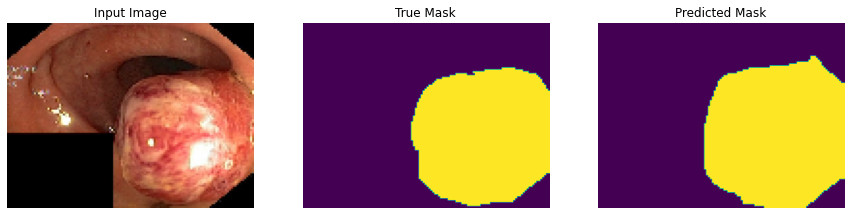

1/1 [==============================] - 1s 986ms/step


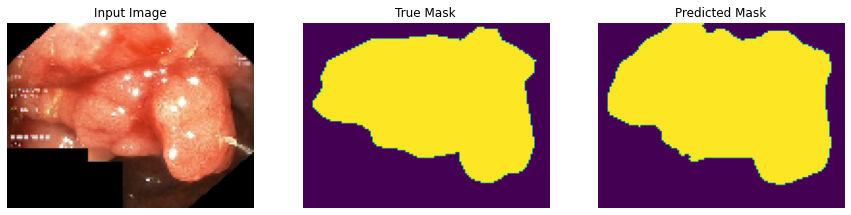

1/1 [==============================] - 1s 1s/step


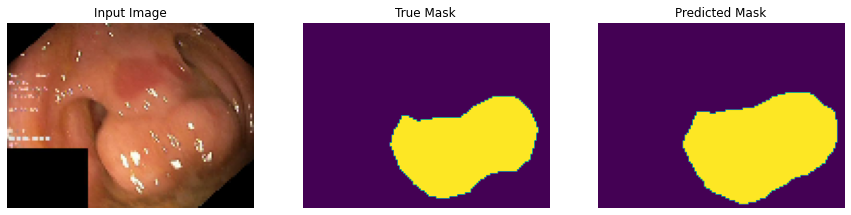

1/1 [==============================] - 1s 1s/step


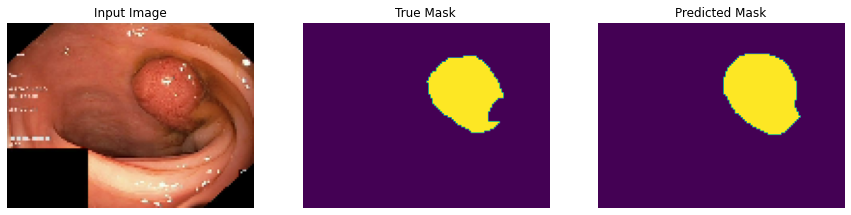

1/1 [==============================] - 1s 926ms/step


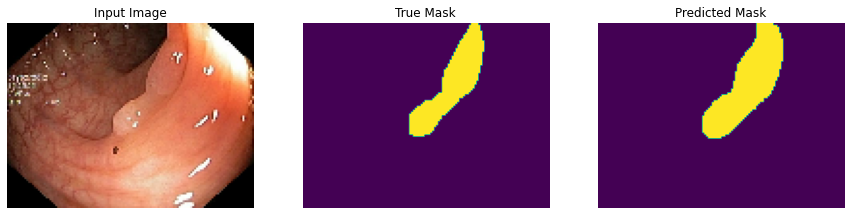

1/1 [==============================] - 1s 915ms/step


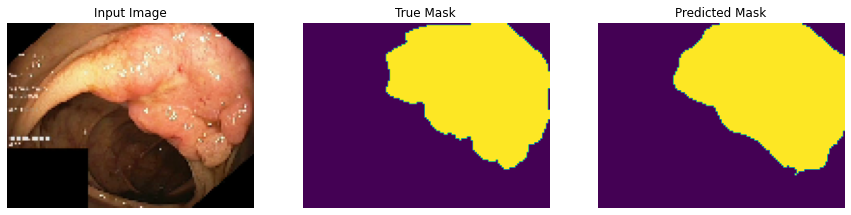

In [123]:
show_predictions(train_dataset, 6)